# Compare predictions
This notebook includes a comparison between the predictions of the hydroestimator, the cnn and the mlp on the rain gauge data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
from matplotlib import cm
import torch
import xarray as xr
import pandas as pd
import os
import datetime

import cartopy
import cartopy.crs as ccrs
from pyresample import load_area, geometry

import quantnn

In [2]:
plt.style.use('seaborn-whitegrid')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
SMALL_SIZE = 16 #8
MEDIUM_SIZE = 18 #10
BIGGER_SIZE = 20 #12
matplotlib.rc('font', size=SMALL_SIZE)          # controls default text sizes
matplotlib.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [59]:
#colors
color_HE_corr = '#ec6726'
color_HE ='#d1b126'
color_cnn ='#72196d'
color_mlp = '#327a4f'
color_gauges = '#64a6a1'
color_neutral = '#990909'
color_grid = "#e9e9e9"

#alpha
alpha_HE_corr_hist = 0.4
alpha_gauges_hist = 0.3

In [5]:
#cmap
big = cm.get_cmap('magma', 512)
newcmp = ListedColormap(big(np.linspace(0.05, 0.95, 256)))

In [6]:
f = open('../path_to_data.txt', "r")
path_to_dataset = os.path.join(f.readline().rstrip("\n"))
f.close() 

In [7]:
combined_all = xr.open_dataset(os.path.join(path_to_dataset,'combined.nc'))

In [8]:
combined_all

<xarray.Dataset>
Dimensions:                  (location: 609, time: 738)
Coordinates:
  * location                 (location) int64 0 1 2 3 4 ... 604 605 606 607 608
  * time                     (time) datetime64[ns] 2020-12-01T01:00:00 ... 20...
Data variables:
    xception_posterior_mean  (time, location) float32 ...
    xception_Q0.95           (time, location) float32 ...
    xception_Q0.99           (time, location) float32 ...
    mlp_posterior_mean       (time, location) float32 ...
    mlp_Q0.95                (time, location) float32 ...
    mlp_Q0.99                (time, location) float32 ...
    HE_precip                (time, location) float64 ...
    HE_precip_corr           (time, location) float64 ...
    gauge_precip             (time, location) float64 ...

### Metadata

In [9]:
metadata = pd.read_pickle(os.path.join(path_to_dataset, 'real_rain_gauge_data', 'general_rain_gauge_info.pckl'))

In [10]:
#metadata[(metadata.lon< -43.2) & (metadata.lat< 22.5) & (metadata.state=='RJ')] #429

### NaNs

In [11]:
print('NaNs in gauges:', np.isnan(combined_all.gauge_precip.values).sum())
print('NaNs in HE:', np.isnan(combined_all.HE_precip.values).sum())
print('NaNs in HE corr:', np.isnan(combined_all.HE_precip_corr.values).sum())
print('NaNs in MLP:', np.isnan(combined_all.mlp_posterior_mean.values).sum())
print('NaNs in CNN:', np.isnan(combined_all.xception_posterior_mean.values).sum())

NaNs in gauges: 165555
NaNs in HE: 6090
NaNs in HE corr: 6090
NaNs in MLP: 1759
NaNs in CNN: 1759


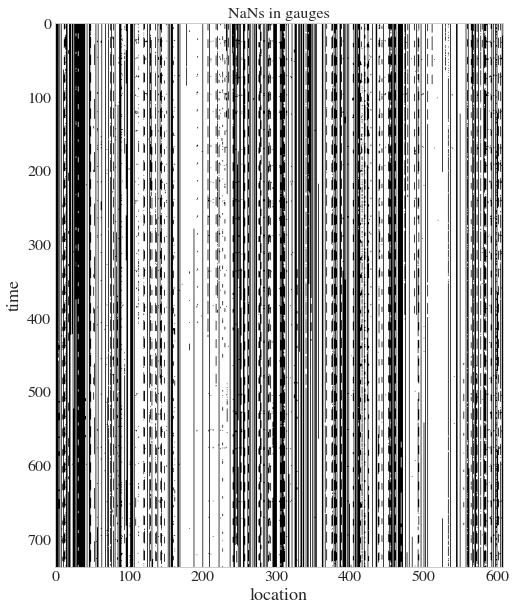

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
data = combined_all.gauge_precip.values
m = np.zeros((data.shape[0], data.shape[1]))
m[np.isnan(data)] = 1
ax.imshow(m, cmap='binary')
ax.set_xlabel('location')
ax.set_ylabel('time')
ax.set_title('NaNs in gauges')
ax.grid(False)
plt.show()

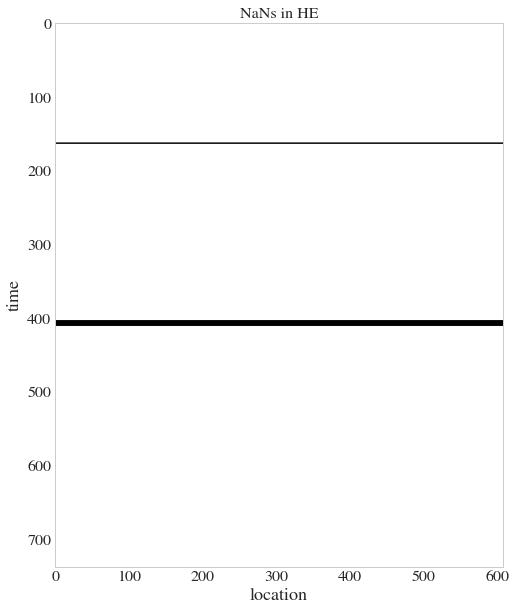

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
data = combined_all.HE_precip.values
m = np.zeros((data.shape[0], data.shape[1]))
m[np.isnan(data)] = 1
ax.imshow(m, cmap='binary')
ax.set_xlabel('location')
ax.set_ylabel('time')
ax.set_title('NaNs in HE')
ax.grid(False)
plt.show()

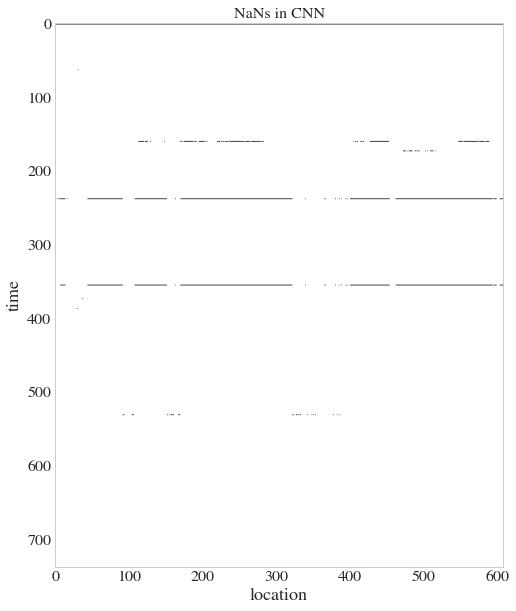

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
data = combined_all.xception_posterior_mean.values
m = np.zeros((data.shape[0], data.shape[1]))
m[np.isnan(data)] = 1
ax.imshow(m, cmap='binary')
ax.set_xlabel('location')
ax.set_ylabel('time')
ax.set_title('NaNs in CNN')
ax.grid(False)
plt.show()

In [15]:
mask = np.zeros((combined_all.gauge_precip.values.shape[0], combined_all.gauge_precip.values.shape[1]))
mask[np.isnan(combined_all.gauge_precip.values)] = 1
mask[np.isnan(combined_all.HE_precip.values)] = 1
mask[np.isnan(combined_all.xception_posterior_mean.values)] = 1
print(mask)
print('missing values fraction:', mask.sum()/len(mask.flatten()))

[[0. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 0. 0.]
 ...
 [0. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]]
missing values fraction: 0.3793793192447524


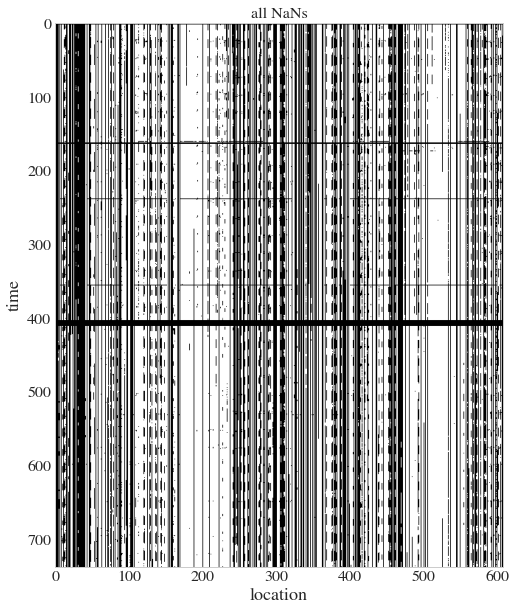

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(mask, cmap='binary')
ax.set_xlabel('location')
ax.set_ylabel('time')
ax.set_title('all NaNs')
ax.grid(False)
plt.show()

In [17]:
# Make sure that comparison is done only where values are present in all datasets.
combined = combined_all.copy()
combined = combined.where(mask==0)

### Single rain gauge over time

In [18]:

def plotGaugeTimeseries(ind,start=0,end=-1):
    fig, ax = plt.subplots(figsize=(16,8))
    #plt.plot(combined.time, combined.mlp_posterior_mean[:, ind], label='mlp')
    plt.plot(combined.time[start:end], combined.xception_posterior_mean[start:end, ind], color=color_cnn, label='CNN')
    plt.fill_between(combined.time[start:end], combined['xception_Q0.95'][start:end, ind],alpha=0.07, color=color_cnn)
    plt.fill_between(combined.time[start:end], combined['xception_Q0.99'][start:end, ind],alpha=0.1, color=color_cnn)
    #plt.plot(combined.time, combined.HE_precip[:, ind], label='HE')
    plt.plot(combined.time[start:end], combined.HE_precip_corr[start:end, ind], label='corrected HE', color=color_HE_corr)
    plt.plot(combined.time[start:end], combined.gauge_precip[start:end, ind], label='gauge', color=color_gauges)
    ax.grid(True,which="both",ls="--",c=color_grid)
    ax.set_ylabel('rain (mm)')
    ax.set_xlabel('datetime (hour)')
    ax.legend()

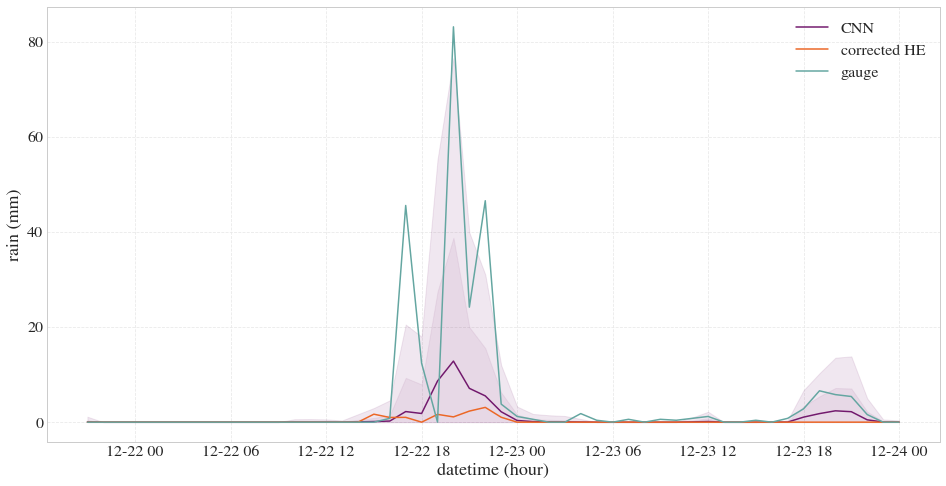

In [19]:
plotGaugeTimeseries(429,500,552) # Xerém

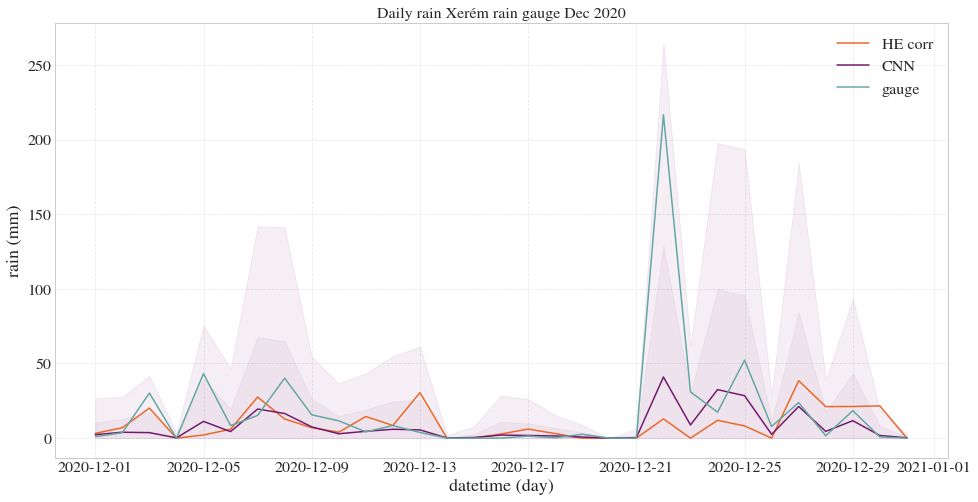

In [20]:

ind = 429
daym = combined.copy()
daym = daym.resample(time='D').sum()
fig, ax = plt.subplots(figsize=(16,8))
#plt.plot(daym.time, daym.mlp_posterior_mean[:, ind], label='mlp')
#ax.plot(daym.time, daym.HE_precip[:, ind], label='HE', color='#e6e6e6')
ax.fill_between(daym.time, daym['xception_Q0.99'][:, ind], alpha=0.07, color=color_cnn)
ax.fill_between(daym.time, daym['xception_Q0.95'][:, ind], alpha=0.05, color=color_cnn)

ax.plot(daym.time, daym.HE_precip_corr[:, ind], label='HE corr', color=color_HE_corr)
ax.plot(daym.time, daym.xception_posterior_mean[:, ind], label='CNN', color=color_cnn)
ax.plot(daym.time, daym.gauge_precip[:, ind], label='gauge', color=color_gauges)

ax.grid(True,which="both",ls="--",c=color_grid)
ax.set_ylabel('rain (mm)')
ax.set_xlabel('datetime (day)')
ax.set_title('Daily rain Xerém rain gauge Dec 2020')
ax.legend()

### Scalar metrics

In [21]:
def Bias(a,b,dataset,mask):
    bias = np.mean(np.subtract(dataset[a].values,dataset[b].values)[mask==0])
    return(bias)

def MAE(a,b,dataset,mask):
    mae = np.mean(np.abs(np.subtract(dataset[a].values,dataset[b].values)[mask==0]))
    return(mae)

def MSE(a,b,dataset,mask):
    mse = np.mean(np.square(np.subtract(dataset[a].values,dataset[b].values)[mask==0]))
    return(mse)

#### Bias

In [22]:
print('HE:',Bias('gauge_precip','HE_precip',combined,mask))
print('HE corr:',Bias('gauge_precip','HE_precip_corr',combined,mask))
print('MLP:',Bias('gauge_precip','mlp_posterior_mean',combined,mask))
print('CNN:',Bias('gauge_precip','xception_posterior_mean',combined,mask))

HE: -0.1041845413295188
HE corr: 0.006546504557844834
MLP: 0.02128214204459453
CNN: -0.004233128358052377


#### MAE

In [23]:
print('HE:',MAE('gauge_precip','HE_precip',combined,mask))
print('HE corr:',MAE('gauge_precip','HE_precip_corr',combined,mask))
print('MLP:',MAE('gauge_precip','mlp_posterior_mean',combined,mask))
print('CNN:',MAE('gauge_precip','xception_posterior_mean',combined,mask))

HE: 0.39354618014600884
HE corr: 0.3000981773968421
MLP: 0.26460390683247
CNN: 0.23152983903431412


#### MSE

In [24]:
print('HE:',MSE('gauge_precip','HE_precip',combined,mask))
print('HE corr:',MSE('gauge_precip','HE_precip_corr',combined,mask))
print('MLP:',MSE('gauge_precip','mlp_posterior_mean',combined,mask))
print('CNN:',MSE('gauge_precip','xception_posterior_mean',combined,mask))

HE: 3.9399494848424386
HE corr: 2.4381287135261074
MLP: 2.03985636993056
CNN: 1.698436812975142


### Histograms 

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80.]


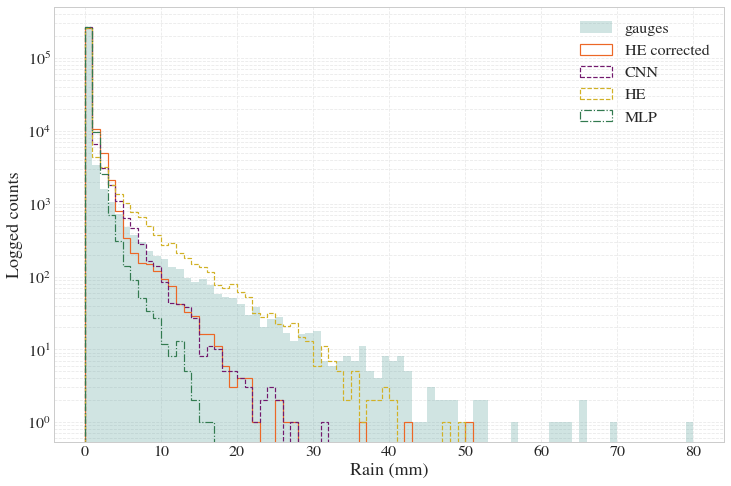

In [61]:
bins = np.linspace(0,80,81)
print(bins)

histtype='step'
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(combined.gauge_precip.values[mask==0].flatten(), histtype='bar', bins=bins, alpha=alpha_gauges_hist, label='gauges', color=color_gauges)
ax.hist(combined.HE_precip_corr.values[mask==0].flatten(), histtype=histtype, bins=bins, label='HE corrected', color=color_HE_corr, linewidth=1.2)
ax.hist(combined.xception_posterior_mean.values[mask==0].flatten(), histtype=histtype, bins=bins, label='CNN', color=color_cnn, linestyle='dashed', linewidth=1.2)
ax.hist(combined.HE_precip.values[mask==0].flatten(), histtype=histtype, bins=bins, label='HE', color=color_HE, linestyle='dashed', linewidth=1.2)
ax.hist(combined.mlp_posterior_mean.values[mask==0].flatten(), histtype=histtype, bins=bins, label='MLP', color=color_mlp, linestyle='dashdot', linewidth=1.2)
#a.hist(combined['xception_Q0.95'].values[mask==0].flatten(), histtype=histtype, bins=bins, label='Q')
ax.set_yscale("log")
ax.grid(True,which="both",ls="--",c=color_grid)
ax.set_xlabel('Rain (mm)')
ax.set_ylabel('Logged counts')
ax.legend()
plt.show()


### By region

In [26]:
reg = ['N', 'SE', 'CW', 'S', 'NE'] #np.unique(metadata.region)
print(reg)
mse_by_region = np.zeros((len(reg),4))

['N', 'SE', 'CW', 'S', 'NE']


In [27]:
for i in range(len(reg)):
    locs = list(metadata.index[metadata.region == reg[i]])
    print(len(locs))
    selection = combined.copy().isel(location=locs)
    mse_by_region[i,0] = MSE('gauge_precip', 'HE_precip', selection, mask[:,locs])
    mse_by_region[i,1] = MSE('gauge_precip', 'HE_precip_corr', selection, mask[:,locs])
    mse_by_region[i,2] = MSE('gauge_precip', 'mlp_posterior_mean', selection, mask[:,locs])
    mse_by_region[i,3] = MSE('gauge_precip', 'xception_posterior_mean', selection, mask[:,locs])

100
149
115
95
150


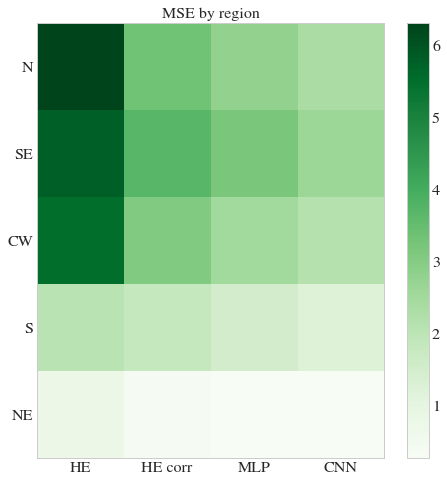

In [28]:

fig, ax = plt.subplots(figsize=(8,8))
m = ax.imshow(mse_by_region, cmap='Greens')
ax.set_yticks(list(range(len(reg))))
ax.set_yticklabels(reg)
mods = ['HE', 'HE corr', 'MLP', 'CNN']
ax.set_xticks(list(range(len(mods))))
ax.set_xticklabels(mods)
ax.set_title('MSE by region')
ax.grid(False)
fig.colorbar(m)
plt.show()

### Diurnal cycle

In [29]:
import datetime
import timezonefinder, pytz

tf = timezonefinder.TimezoneFinder()

def getTimeZone(lat, lon):
    timezone_str = tf.certain_timezone_at(lat=lat, lng=lon)

    if timezone_str is None:
        print( "Could not determine the time zone")
        return(None)
    else:
        # Assuming same utc offset at given location throughout whole timeperiod Dec 2020
        timezone = pytz.timezone(timezone_str)
        dt = datetime.datetime(2020,12,1)
    return(timezone.utcoffset(dt).total_seconds()/3600.0)

In [30]:
def UTCtoLocal(dataset,mdat):
    shift = []
    for i in mdat.index:
        shift.append(getTimeZone(mdat.lat[i], mdat.lon[i]))
        
    ind_to_shift = []
    for s in np.unique(shift):
        ind_to_shift.append(list(np.where(shift==s)))
        
    di = dataset.copy()
    dj = dataset.copy()
    
    abs_diff = int(np.max(np.abs(np.unique(shift))))
    to_add = dj.time.min()+np.timedelta64(abs_diff,'h')
    
    dj = dj.where(dj.time<to_add, drop=True)
    dj = dj.where(dj.time<di.time.min())
    
    dj = dj.assign_coords(time=di.time[:abs_diff]-np.timedelta64(abs_diff,'h'))
    
    dext = xr.concat([dj, di], "time")
    
    datasets = []
    for i in range(len(np.unique(shift))):
        print(int(np.unique(shift)[i]))
        #print(ind_to_shift[i][0])
        selection = dext.copy().isel(location=ind_to_shift[i][0])
        selection = selection.shift(time=int(np.unique(shift)[i]))
        datasets.append(selection)    
        
    dshifted = xr.concat(datasets, "location")
    dshifted = dshifted.sortby("location")
    
    return(dshifted)

In [31]:
combined_local_time = UTCtoLocal(combined, metadata)

-5
-4
-3
-2


In [32]:
def diurnal_cycle(dataset):
    di = dataset.copy()
    di = di.mean(dim='location')
    di = di.groupby('time.hour')
    st = di.std()
    me = di.mean()

    fig, ax = plt.subplots(figsize=(10,10))

    ax.plot(me.hour, me.gauge_precip, label='gauges', color=color_gauges)
    ax.plot(me.hour, me.HE_precip_corr, label='HE corrected', linestyle='dashdot', color=color_HE_corr)
    ax.plot(me.hour, me.xception_posterior_mean, label='CNN', linestyle='dashed', color=color_cnn)
    ax.fill_between(me.hour, me.gauge_precip+st.gauge_precip,
                    me.gauge_precip-st.gauge_precip, linestyle='--', alpha=0.1, color=color_gauges)
    ax.fill_between(me.hour, me.HE_precip_corr+st.HE_precip_corr, 
                    me.HE_precip_corr-st.HE_precip_corr, alpha=0.1, color=color_HE_corr)
    ax.fill_between(me.hour, me.xception_posterior_mean+st.xception_posterior_mean,
                       me.xception_posterior_mean-st.xception_posterior_mean, alpha=0.1, color=color_cnn)
    ax.grid(True,which="both",ls="--",c=color_grid)
    ax.set_ylabel('Rain (mm)')
    ax.set_xlabel('Time (hour)')
    ax.legend(loc='upper left')

In [33]:
#diurnal_cycle(combined)

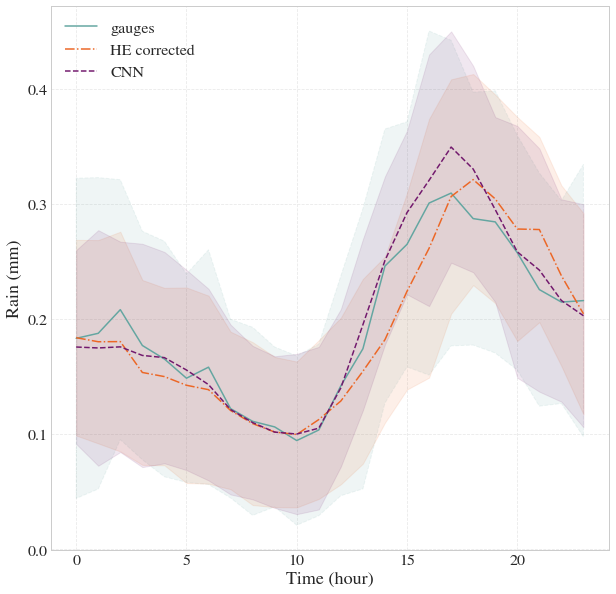

In [34]:
diurnal_cycle(combined_local_time) #time with local utc offset

### 2D histograms

[-40. -39. -38. -37. -36. -35. -34. -33. -32. -31. -30. -29. -28. -27.
 -26. -25. -24. -23. -22. -21. -20. -19. -18. -17. -16. -15. -14. -13.
 -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.]


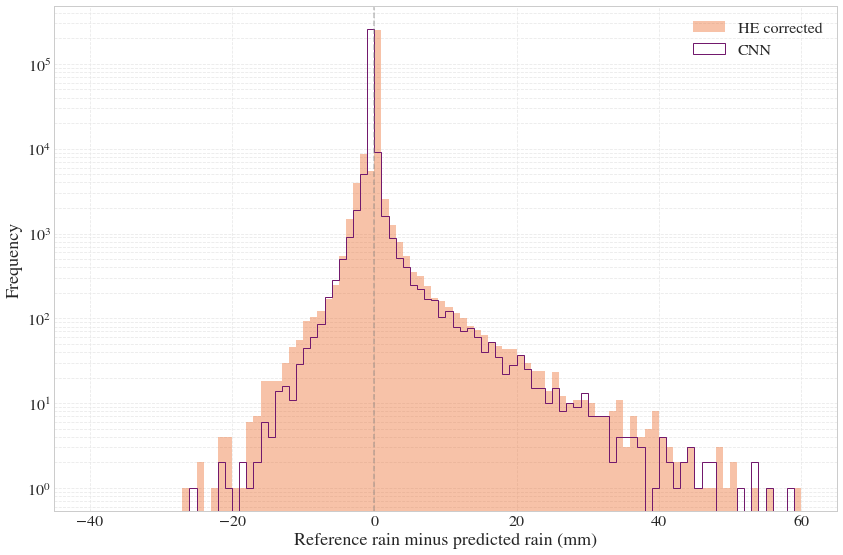

In [57]:

bins = np.linspace(-40,60,101)
print(bins)
f, ax = plt.subplots(figsize=(12,8))
ax.set_yscale("log")
ax.hist(np.subtract(combined['gauge_precip'].values,
                    combined['HE_precip_corr'].values)[mask==0].flatten(), 
           alpha=alpha_HE_corr_hist, bins=bins, color=color_HE_corr, label='HE corrected')
ax.hist(np.subtract(combined['gauge_precip'].values,
                    combined['xception_posterior_mean'].values)[mask==0].flatten(), 
        bins=bins, color=color_cnn, label='CNN', histtype='step')
ax.set_ylabel('Frequency')
ax.set_xlabel('Reference rain minus predicted rain (mm)')
ax.axvline(x=0.0, color='grey', alpha=0.5, linestyle='dashed')
ax.grid(True,which="both",ls="--",c=color_grid)
ax.legend()
plt.tight_layout()
#plt.savefig('../plots/thesis/diff_gauge.pdf', bbox_inches='tight')

In [36]:
def hist2D(y_true, y_pred, norm_type=None):
    bins = np.logspace(-1, 2, 50)# 81)
    
    print('max y_true', np.max(y_true))
    
    freqs, _, _ = np.histogram2d(y_true, y_pred, bins=bins)
    freqs[freqs==0.0] = np.nan
    vmax = None
    extend = 'neither'

    if norm_type==None:
        freqs_normed = freqs
    elif norm_type=='colwise':
        freqs_normed = freqs
        for col_ind in range(freqs.shape[0]):
            if np.isnan(freqs[col_ind, :]).all():
                freqs_normed[col_ind, :] = np.array([np.nan] * freqs.shape[1])
            else:
                freqs_normed[col_ind, :] = freqs[col_ind, :] / np.nansum(freqs[col_ind, :])
        vmax=np.percentile(freqs_normed[np.isnan(freqs_normed)==False], 95)
        extend = 'max'
        print(vmax)     

    f, ax = plt.subplots(figsize=(8,8))
    m = ax.pcolormesh(bins, bins, freqs_normed.T, cmap=newcmp, vmax=vmax)
    ax.set_xlim([1e-1, 1e2])
    ax.set_ylim([1e-1, 1e2])

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Reference rain rate, gauges (mm)")
    ax.set_ylabel("Predicted rain rate (mm)")
    ax.plot(bins, bins, c="grey", ls="--")
    ax.grid(True,which="both",ls="--",c=color_grid)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    plt.colorbar(m, cax=cax, extend=extend)
    
    plt.tight_layout()

max y_true 83.2


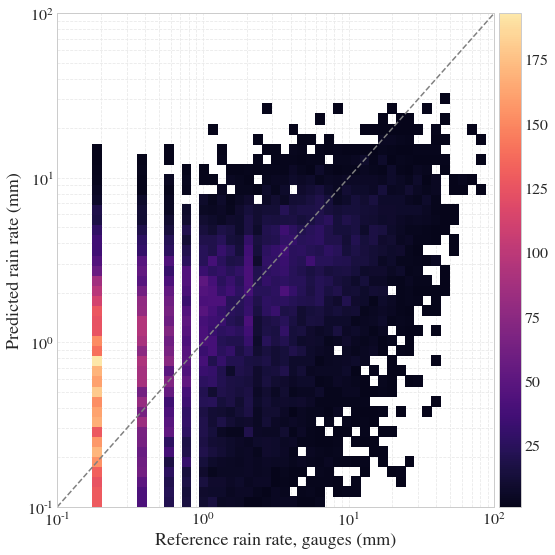

In [37]:
hist2D(combined.gauge_precip.values[mask==0].flatten(), 
      combined.xception_posterior_mean.values[mask==0].flatten())

max y_true 83.2
0.08333333333333331


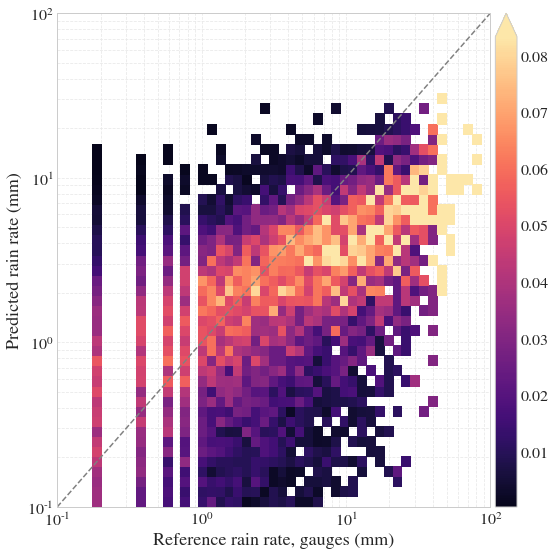

In [38]:
hist2D(combined.gauge_precip.values[mask==0].flatten(), 
      combined.xception_posterior_mean.values[mask==0].flatten(), norm_type='colwise')

max y_true 83.2


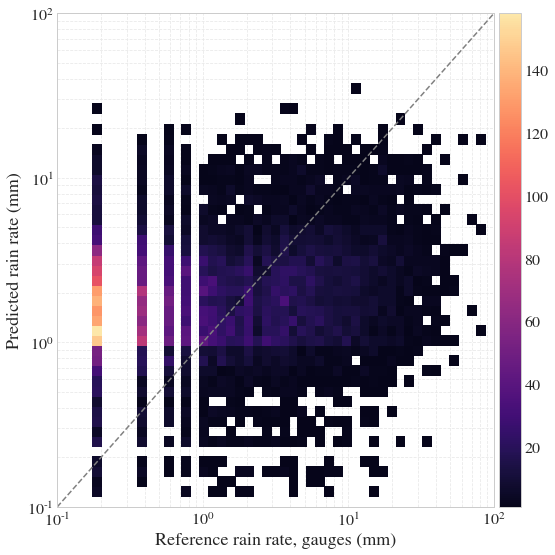

In [40]:
hist2D(combined.gauge_precip.values[mask==0].flatten(), 
      combined.HE_precip_corr.values[mask==0].flatten())

max y_true 83.2


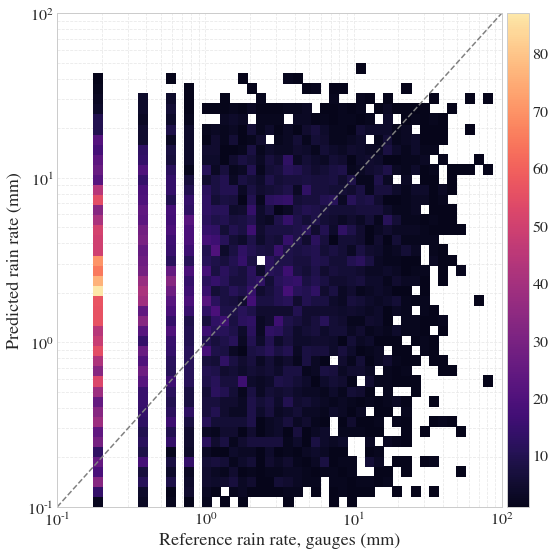

In [41]:
hist2D(combined.gauge_precip.values[mask==0].flatten(), 
      combined.HE_precip.values[mask==0].flatten())

max y_true 83.2


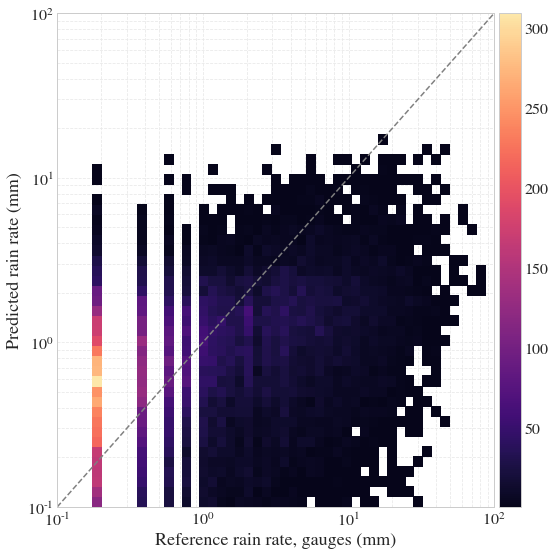

In [42]:
hist2D(combined.gauge_precip.values[mask==0].flatten(), 
      combined.mlp_posterior_mean.values[mask==0].flatten())

In [53]:
def diff2(b,dataset,mask):
    y_true = dataset['gauge_precip'].values[mask==0].flatten()
    diff = (dataset['gauge_precip'].values - dataset[b].values)[mask==0].flatten()#np.subtract(dataset[a].values, dataset[b].values)[mask==0].flatten()
    
    print('y true max', np.max(y_true))
    print('diff max', np.max(diff))
    
    print('y true min', np.min(y_true))
    print('diff min', np.min(diff))

    bins_y = np.linspace(-30,90,100)
    bins_x = bins_y
    
    freqs_fc, _, _ = np.histogram2d(y_true, diff, bins=(bins_x,bins_y))
    freqs_fc[freqs_fc==0.0] = np.nan

    norm = LogNorm(vmin=np.nanmin(freqs_fc), vmax=1e6)#np.nanmax(freqs_fc), clip=1e6)
        
    f, ax = plt.subplots(figsize=(8, 8))

    ax.axhline(0, bins_x[0], bins_x[-1], zorder=0, c="grey", ls="--", alpha=0.5)
    ax.plot(bins_x, bins_y,  zorder=0, c=color_grid, ls="--", alpha=0.5)
    m = ax.pcolormesh(bins_x, bins_y, freqs_fc.T, cmap=newcmp, norm=norm)
    ax.grid(True,which="both",ls="--",c=color_grid)  
    ax.set_aspect(1.0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    plt.colorbar(m, cax=cax)
    
    ax.set_xlabel("Reference rain rate, gauges (mm)")
    ax.set_ylabel("Reference minus predicted rain rate (mm)")
    plt.tight_layout()

In [55]:
#diff2('xception_posterior_mean',combined,mask)

In [49]:
def Classification(y,p, threshold=1e-1):


    TP = (p[y>threshold]>threshold).sum() #Is rain, predict rain
    TN = (p[y<=threshold]<=threshold).sum() #Is no rain, predict no rain
    FP = (p[y<=threshold]>threshold).sum() #Is no rain, predict rain
    FN = (p[y>threshold]<=threshold).sum() #Is rain, predict no rain

    fig, ax = plt.subplots()
    confusion_matrix = np.array([[FP, TP], [TN, FN]])#np.array([[TP, FN], [FP, TN]])
    m = ax.imshow(confusion_matrix, cmap='Greens')
    ax.set_ylabel('Predicted class')
    ax.set_xlabel('True class')
    ax.grid(False)
    ax.set_xticks(ticks=[0,1])
    ax.set_xticklabels(labels=['No rain', 'Rain',])
    ax.set_yticks(ticks=[1,0])
    ax.set_yticklabels(labels=['No rain', 'Rain'])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    plt.colorbar(m, cax=cax)
    
    # Loop over data dimensions and create text annotations.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            text = ax.text(j, i, confusion_matrix[i, j],
                           ha="center", va="center", color="orange", fontsize=18)
    plt.show()
    
    print('TP, Is rain, predict rain:', TP)
    print('TN, Is no rain, predict no rain:', TN)
    print('FP, Is no rain, predict rain:', FP)
    print('FN, Is rain, predict no rain:', FN)

    TPR = (TP/(TP+FN)) #Sensitivity or Recall (POD=hits/(hits+misses))
    print('TPR', "{:.2f}".format(TPR))
    TNR = (TN/(TN+FP)) #Specificity
    #print('TPR', "{:.2f}".format(TNR))
    PPV = (TP/(TP+FP)) #Precision
    #print('PPV', "{:.2f}".format(PPV))
    PNV = (TN/(TN+FN))
    #print('PNV', "{:.2f}".format(PNV))

    FAR = (FP/(FP+FN)) #false alarms/(false alarms+hits)
    print('FAR', "{:.2f}".format(FAR)) 

    CSI = TP/(TP+FN+FP) #hits/(hits+misses+false alarms)
    print('CSI', "{:.2f}".format(CSI))

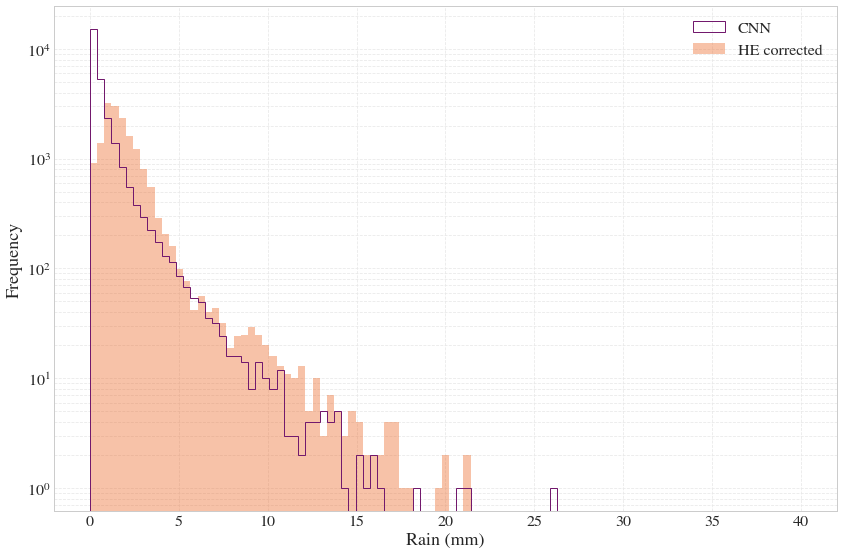

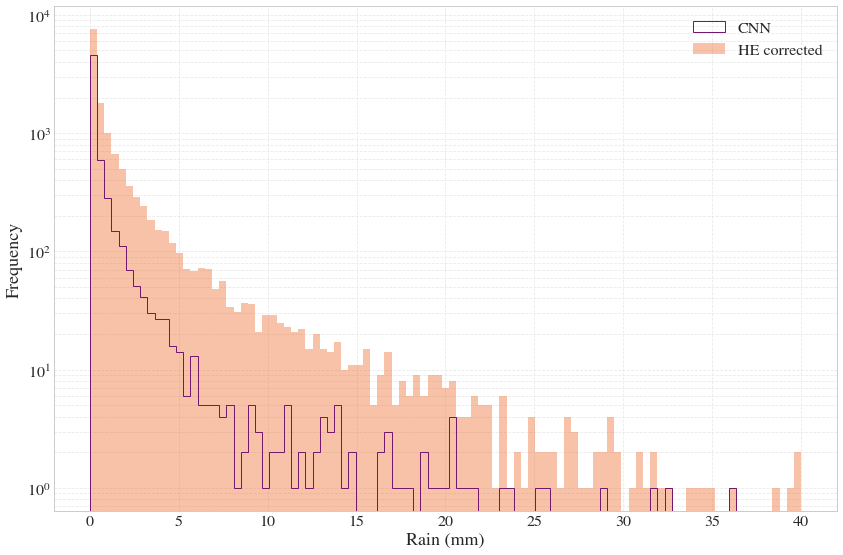

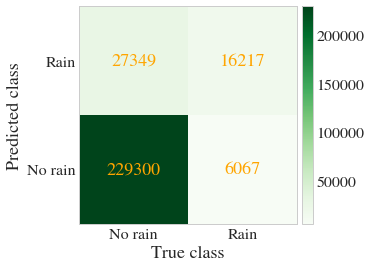

TP, Is rain, predict rain: 16217
TN, Is no rain, predict no rain: 229300
FP, Is no rain, predict rain: 27349
FN, Is rain, predict no rain: 6067
TPR 0.73
FAR 0.82
CSI 0.33


In [58]:
threshold = 1e-1
y = combined.gauge_precip.values[mask==0].flatten()
p = combined.xception_posterior_mean.values[mask==0].flatten()
r = combined.HE_precip_corr.values[mask==0].flatten()


bins=np.linspace(0,40,100)
pp = p[y<=threshold]
rr = r[y<=threshold]
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(pp[pp>threshold], bins=bins, color=color_cnn, histtype='step', label='CNN')
ax.hist(rr[rr>threshold], bins=bins, alpha=alpha_HE_corr_hist, color=color_HE_corr,  label='HE corrected')
ax.set_yscale("log")
ax.grid(True,which="both",ls="--",c=color_grid) 
#ax.set_ylim([5e-1, 1e4])
ax.set_ylabel('Frequency')
ax.set_xlabel('Rain (mm)')
#ax.set_title('Distribution of non-zero predicted rain corresponding to no rain reference values')
ax.legend()
plt.tight_layout()
#plt.savefig('../plots/thesis/nonzero_pred_no_true_gauge.pdf', bbox_inches='tight')
plt.show()


yp = y[p<=threshold]
yr = y[r<=threshold]
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(yp[yp>threshold], bins=bins, color=color_cnn, histtype='step', label='CNN')
ax.hist(yr[yr>threshold], bins=bins, alpha=alpha_HE_corr_hist, color=color_HE_corr, label='HE corrected')
ax.set_yscale("log")
ax.grid(True,which="both",ls="--",c=color_grid) 
#ax.set_ylim([5e-1, 1e4])
ax.set_ylabel('Frequency')
ax.set_xlabel('Rain (mm)')
#ax.set_title('Distribution of non-zero reference values corresponding to no rain predictions')
ax.legend()
plt.tight_layout()
#plt.savefig('../plots/thesis/zero_pred_true_gauge.pdf', bbox_inches='tight')
plt.show()

Classification(y,p)

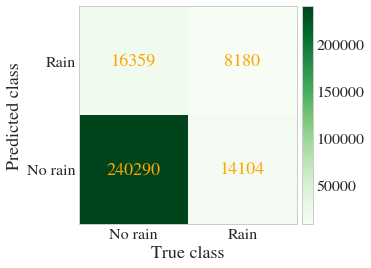

TP, Is rain, predict rain: 8180
TN, Is no rain, predict no rain: 240290
FP, Is no rain, predict rain: 16359
FN, Is rain, predict no rain: 14104
TPR 0.37
FAR 0.54
CSI 0.21


In [52]:
y = combined.gauge_precip.values[mask==0].flatten()
p = combined.HE_precip_corr.values[mask==0].flatten()
Classification(y,p)

### Unique values in gauges

In [48]:
dat = combined.gauge_precip.values[mask==0].flatten()
print(np.unique(dat))

[ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6
  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4
  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2
  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.
 11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8
 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.  16.2 16.4 16.6
 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8 19.  19.2 19.4
 19.6 19.8 20.  20.2 20.4 20.6 20.8 21.  21.2 21.4 21.6 21.8 22.  22.2
 22.4 22.6 22.8 23.  23.2 23.4 23.6 23.8 24.  24.2 24.4 24.6 24.8 25.
 25.2 25.4 25.6 25.8 26.  26.2 26.4 26.6 26.8 27.  27.2 27.4 27.6 27.8
 28.  28.2 28.4 28.6 28.8 29.  29.2 29.4 29.6 29.8 30.  30.2 30.4 30.6
 30.8 31.  31.4 31.6 32.  32.2 32.4 32.6 33.2 33.6 33.8 34.  34.4 34.6
 34.8 35.  35.2 35.4 35.6 35.8 36.  36.2 36.4 36.6 36.8 37.  37.2 37.6
 38.4 38.6 38.8 39.  39.2 39.6 39.8 40.2 40.4 40.6 40.8 41.2 41.6 41.8
 42.4 42